CSDN csdn_inside: [GMM 高斯混合模型 聚类 Python实现](https://blog.csdn.net/csdn_inside/article/details/85267341)

[西瓜书数据集4.0](https://blog.csdn.net/xxliu_csdn/article/details/86483816)

原理也不多说了。。大致思路就是把数据建立成k个高斯分布，EM迭代N次。最后看每个点在哪个高斯分布的概率最高，就分到那个分布。

这里的computeGamma函数，用来算第i个簇的后验概率γji，用了2层循环，效率不高，本来想向量化的，搞了半天没搞出来。。干脆就先循环吧。。包括后面的fit方法也是一样。。用了很多循环。

X的shape是(n_samples,n_features)

mu的shape是(n_clusters,n_features)

sigma的shape是(n_clusters,n_features,n_features)

alpha的shape是(n_clusters,)

输出的gamma是(n_samples,n_clusters)


类方法fit里面，所有alpha初始为1/n_clusters，所有sigma协方差初始化为0.1，mu随机在样本里面选n_clusters个。

这里为了复现西瓜书的效果，所以指定mu为[[.403,.237],[.714,.346],[.532,.472]]。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
def multiGaussian(x,mu,sigma):
    return 1/((2*np.pi)*pow(np.linalg.det(sigma),0.5))*np.exp(-0.5*(x-mu).dot(np.linalg.pinv(sigma)).dot((x-mu).T))
 
def computeGamma(X,mu,sigma,alpha,multiGaussian):
    n_samples=X.shape[0]
    n_clusters=len(alpha)
    gamma=np.zeros((n_samples,n_clusters))
    p=np.zeros(n_clusters)
    g=np.zeros(n_clusters)
    for i in range(n_samples):
        for j in range(n_clusters):
            p[j]=multiGaussian(X[i],mu[j],sigma[j])
            g[j]=alpha[j]*p[j]
        for k in range(n_clusters):
            gamma[i,k]=g[k]/np.sum(g)
    return gamma
 
class MyGMM():
    def __init__(self,n_clusters,ITER=50):
        self.n_clusters=n_clusters
        self.ITER=ITER
        self.mu=0
        self.sigma=0
        self.alpha=0
      
    def fit(self,data):
        n_samples=data.shape[0]
        n_features=data.shape[1]
        '''
        mu=data[np.random.choice(range(n_samples),self.n_clusters)]
        '''
        alpha=np.ones(self.n_clusters)/self.n_clusters
        
        mu=np.array([[.403,.237],[.714,.346],[.532,.472]])
        
        sigma=np.full((self.n_clusters,n_features,n_features),np.diag(np.full(n_features,0.1)))
        
        for i in range(self.ITER):
            gamma=computeGamma(data,mu,sigma,alpha,multiGaussian)
            alpha=np.sum(gamma,axis=0)/n_samples
            for i in range(self.n_clusters):
                mu[i]=np.sum(data*gamma[:,i].reshape((n_samples,1)),axis=0)/np.sum(gamma,axis=0)[i]
                sigma[i]=0
                for j in range(n_samples):
                    sigma[i]+=(data[j].reshape((1,n_features))-mu[i]).T.dot((data[j]-mu[i]).reshape((1,n_features)))*gamma[j,i]
                sigma[i]=sigma[i]/np.sum(gamma,axis=0)[i]
        self.mu=mu
        self.sigma=sigma
        self.alpha=alpha
        
    def predict(self,data):
        pred=computeGamma(data,self.mu,self.sigma,self.alpha,multiGaussian)
        cluster_results=np.argmax(pred,axis=1)
        return cluster_results


In [20]:
import pandas as pd
data=pd.read_csv('data_watermelon/watermelon_4.csv')

In [21]:
# X = np.array(data.values, dtype=float)

In [23]:
X = data.values

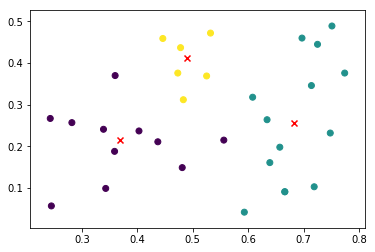

In [24]:
model1=MyGMM(3)
model1.fit(X)
result=model1.predict(X)
plt.scatter(X[:,0],X[:,1],c=result)
plt.scatter(model1.mu[:,0],model1.mu[:,1],marker='x',color='red')